# Сборный проект

**Описание проекта**

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation).

**Описание данных**

- *Name* — название игры
- *Platform* — платформа
- *Year_of_Release* — год выпуска
- *Genre* — жанр игры
- *NA_sales* — продажи в Северной Америке (миллионы проданных копий)
- *EU_sales* — продажи в Европе (миллионы проданных копий)
- *JP_sales* — продажи в Японии (миллионы проданных копий)
- *Other_sales* — продажи в других странах (миллионы проданных копий)
- *Critic_Score* — оценка критиков (максимум 100)
- *User_Score* — оценка пользователей (максимум 10)
- *Rating* — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

**Цель проекта**

Нужно выявить определяющие успешность игры закономерности и отработать принцип работы с данными.

**Импортируем библиотеки**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom
import seaborn as sns

**Шаг 1. Откроем файл с данными и изучим общую информацию**

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Вывод: 
- датафрейм содержит 16715 записей
- названия столбцов некорректные, нужно привести к нижнему регистру
- в таблице есть пропуски
- у некоторых столбцов некорректный тип данных.

**Шаг 2. Подготовим данные**

*Заменим названия стобцов (приведем к нижнему регистру)*

In [5]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


*Проведем поиск дубликатов*

In [6]:
df.duplicated().sum()

0

In [7]:
df[df.duplicated(['name', 'platform', 'year_of_release'])].count()

name               1
platform           2
year_of_release    2
genre              1
na_sales           2
eu_sales           2
jp_sales           2
other_sales        2
critic_score       1
user_score         1
rating             1
dtype: int64

In [8]:
df = df.drop_duplicates(['name', 'platform', 'year_of_release'])
display(df[df.duplicated(['name', 'platform', 'year_of_release'])].count())

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

*Обработаем пропуски*

In [9]:
df.isna().sum()

name                  1
platform              0
year_of_release     269
genre                 1
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8577
user_score         6700
rating             6765
dtype: int64

In [10]:
df = df.dropna(subset = ['name'])
df['name'].isna().sum()

0

*В данном столбце мы удалили строки с пропусками, так как их очень мало, на анализ они не повлияют.*

In [11]:
df = df.dropna(subset=['year_of_release'])
df['year_of_release'].isna().sum()

0

*Так же мы поступили со столбцом `year_of_release`.*

In [12]:
df = df.dropna(subset=['genre'])
df['genre'].isna().sum()

0

*И так же сделали с `genre`.*

In [13]:
df['critic_score'] = df['critic_score'].fillna(-1)
df['critic_score'].isna().sum()

0

*В данном столбце мы заменили пропуски на -1, так как методы `mean()` и `median()` могут привести к неверным данным.*

In [14]:
df['user_score'] = df['user_score'].fillna(-1)
df['user_score'].value_counts()

-1     6605
tbd    2376
7.8     322
8       285
8.2     276
       ... 
0.9       2
1         2
1.1       2
9.7       1
0         1
Name: user_score, Length: 97, dtype: int64

*Данный столбец имеет значение "tbd". Мы провели поиск этой аббревиатуры и выяснили, что это может значить "будет определено позже", то есть оценку еще не поставили. Так же присвоим значение -1, чтобы не допустить некорретных данных.*

In [15]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = -1
df['user_score'].value_counts()

-1     8981
7.8     322
8       285
8.2     276
8.3     252
       ... 
0.2       2
0.5       2
0.7       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

In [16]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [17]:
df['rating'] = df['rating'].fillna('unknown')
df['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

In [18]:
df.isna().sum()

name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

*Пропуски обработаны.*

*Преобразуем данные в нужные типы*

In [19]:
df['year_of_release'] = df['year_of_release'].astype('Int64')
df['critic_score'] = df['critic_score'].astype('int')
df['user_score'] = df['user_score'].astype('float')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  int64  
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
dtypes: Int64(1), float64(5), int64(1), object(4)
memory usage: 1.5+ MB


*В столбце `year_of_release` изменили тип данных на `int`, так как год выпуска - это целое число, которое не может иметь десятичных дробей. В столбце `user_score` содержатся числовые значения, с которыми в дальнейшем будут проводиться расчеты или сравнения, поэтому поменяли тип данных на float. У остальных столбцов корректный тип данных.*

*Посчитаем суммарные продажи во всех регионах*

In [20]:
df['total_sales'] = df[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,unknown,31.38


Вывод: 
- дубликатов в таблице нет
- привели названия столбцов к нижнему регистру
- обработали пропуски
- изменили тип данных
- посчитали суммарные продажи во всех регионах
- разобрали значение tbd ("будет определено позже", то есть оценку еще не поставили).

Пропусками могли послужить человеческий фактор и сбои в программе.

In [21]:
# Комментарий ревьюера
# Посмотрим, что у нас осталось
temp = df.copy() 
list_c = ['name', 'platform', 'year_of_release', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,' : кол-во 0', temp[temp[col_l] == 0][col_l].count(),
        ', процент 0', round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2),'%')
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16443 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  int64  
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
 11  total_sales      16443 non-null  float64
dtypes: Int64(1), float64(6), int64(1), object(4)
memory usage: 1.6+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en co

**Шаг 3. Проведем исследовательский анализ данных**

**Посмотрим, сколько игр выпускалось в разные годы**

In [22]:
df['year_of_release'].describe()

count    16443.000000
mean      2006.485921
std          5.875546
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: year_of_release, dtype: float64

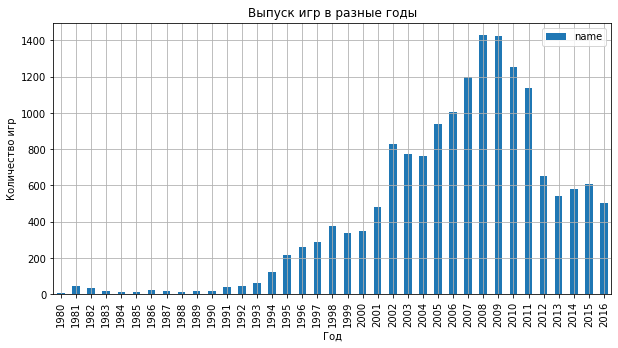

In [23]:
(
    df.pivot_table(index='year_of_release', values='name', aggfunc='count')
    .plot(kind='bar', grid=True, figsize=(10, 5))
)
plt.title('Выпуск игр в разные годы')
plt.xlabel('Год')
plt.ylabel('Количество игр')
plt.show()

Вывод: по графику мы видим, что пик выпуска игр приходится на 2008-2009 годы. С 1992 года количество выпущенных игр только росло, за исключением пары лет. В то время качество игр становилось все лучше, а с приходом новым технологий графика, реализация идей и сюжетов только прогрессировала. Но после 2009 года довольно резко сократилось число выпуска.

**Посмотрим, как менялись продажи по платформам**

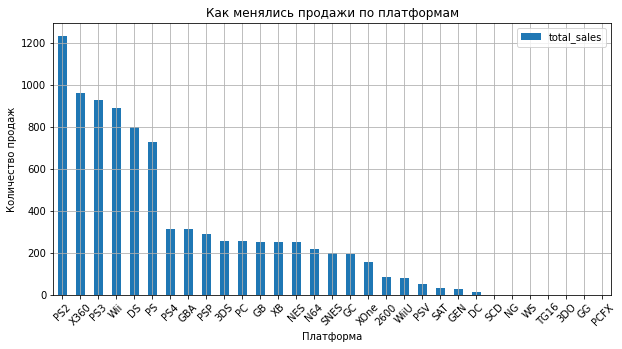

In [24]:
(
    df.pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .plot(kind='bar', grid=True, figsize=(10, 5))
)
plt.title('Как менялись продажи по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество продаж')
plt.xticks(rotation=45)
plt.show()

Вывод: больше всего интернет-магазин продал игры на платформе PS2, за ней следуют X360, PS3, Wii, DS и PS4. Данные платформы довольно популярны, благодаря чему и пользовались спросом на игры.

In [25]:
sales_by_platform = df.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).reset_index().head(6)['platform'].tolist()
sales_by_platform

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

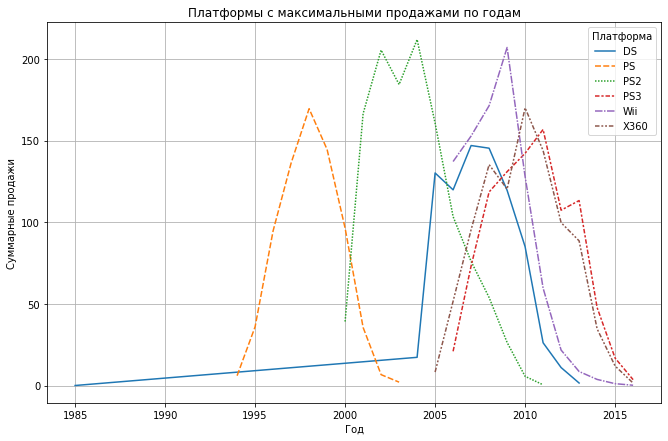

In [26]:
filtered_df = df.query('platform in @sales_by_platform')
sales_distribution = filtered_df.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum')

plt.figure(figsize=(11, 7))
sns.lineplot(data=sales_distribution)
plt.title('Платформы с максимальными продажами по годам')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи')
plt.legend(title='Платформа')
plt.grid()
plt.show()

Вывод: судя по графику, каждая платформа имеет резкий рост продаж и резкий спад. Жизненный цикл платформ в среднем занимает 10 лет с начала появления на рынке продаж до ее исчезновения.

In [27]:
# Комментарий ревьюера
temp = df.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()

7.0

**Возьмем данные за 2013 год для последующего исследования. Данные за предыдущие года учитывать не будем.**

**Какие платформы лидируют по продажам, растут или падают?**

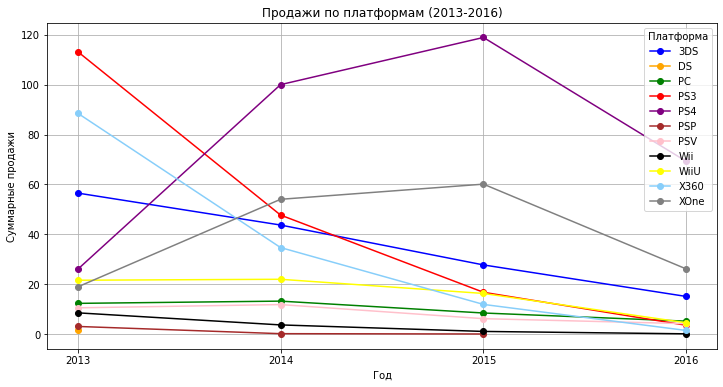

In [28]:
filtered_df = df[(df['year_of_release'] >= 2013)] # отфильтруем данные за актуальный период 2013-2016 год
sales_by_platform = filtered_df.groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()

plt.figure(figsize=(12, 6))
colors = {
    '3DS': 'blue', 
    'DS': 'orange',   
    'PC': 'green',
    'PS3': 'red',
    'PS4': 'purple',
    'PSP': 'brown',
    'PSV': 'pink',
    'Wii': 'black',
    'WiiU': 'yellow',
    'X360': 'lightskyblue',
    'XOne': 'gray'
}

for platform in sales_by_platform['platform'].unique():
    platform_data = sales_by_platform[sales_by_platform['platform'] == platform]
    plt.plot(platform_data['year_of_release'], platform_data['total_sales'], marker='o', label=platform, color=colors.get(platform, 'gray'))
    
plt.title('Продажи по платформам (2013-2016)')
plt.xlabel('Год')
plt.ylabel('Суммарные продажи')
plt.xticks(sales_by_platform['year_of_release'].unique())
plt.legend(title='Платформа')
plt.grid()
plt.show()

Вывод: судя по графику лидируют платформы PS4 и XOne, но продажи резко снизились в 2015 году. На протяжении трех лет у всех остальных платформ наблюдается падение продаж.

**Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам**

In [29]:
filtered_df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000,2233.000000
mean,2014.477385,0.196019,0.175652,0.063045,0.053726,31.407524,3.048724,0.488442
std,1.089439,0.547730,0.512451,0.233997,0.165693,37.282494,3.963069,1.235226
min,2013.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.010000
25%,2014.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.030000
50%,2014.000000,0.020000,0.030000,0.010000,0.010000,-1.000000,3.500000,0.110000
75%,2015.000000,0.150000,0.130000,0.050000,0.040000,72.000000,7.100000,0.400000
max,2016.000000,9.660000,9.090000,4.350000,3.960000,97.000000,9.300000,21.050000


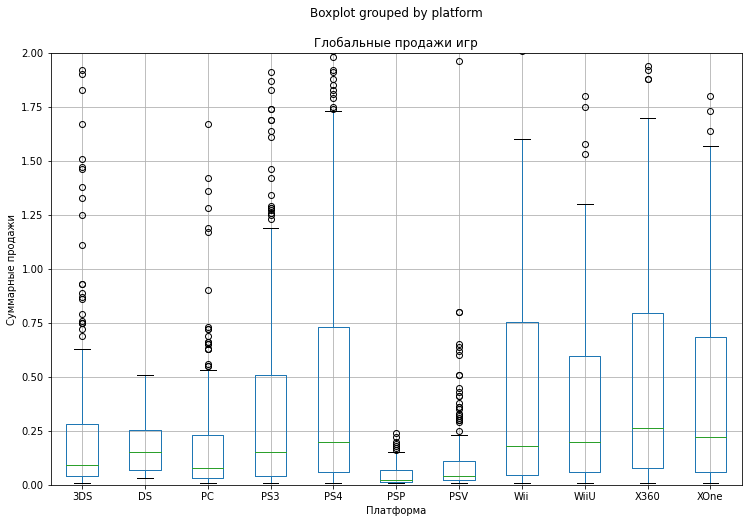

In [30]:
filtered_df.boxplot(by='platform', column=['total_sales'], figsize=(12, 8))
plt.ylim(0,2)
plt.title('Глобальные продажи игр')
plt.xlabel('Платформа')
plt.ylabel('Суммарные продажи')
plt.show()

Вывод: платформа X360 больше всех выделяется, потому что медиана и третий квартиль выше остальных платформ. Максимальная точка выше всех имеется у PS4. Недалеко находится XOne и Wii. Как мы видим, выбросы есть у всех платформ, кроме DS.

**Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами.**

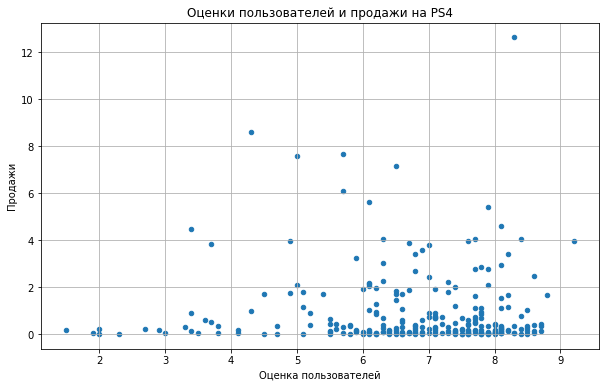

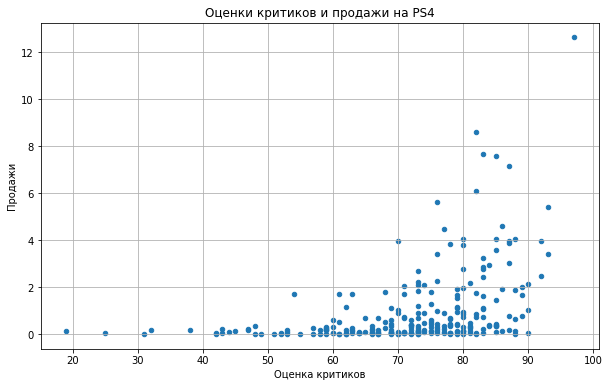

In [32]:
filtered_ps4 = filtered_df[filtered_df.platform == "PS4"] # Выберем PS4
user_score_filtered = filtered_ps4[filtered_ps4.user_score != -1]

user_score_filtered.plot(kind='scatter', x='user_score', y='total_sales', figsize=(10, 6))
plt.title('Оценки пользователей и продажи на PS4')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи')
plt.grid()
plt.show()
                                   
critic_score_filtered = filtered_ps4[filtered_ps4.critic_score != -1]

critic_score_filtered.plot(kind='scatter', x='critic_score', y='total_sales', figsize=(10, 6))
plt.title('Оценки критиков и продажи на PS4')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи')
plt.grid()
plt.show()

In [33]:
user_corr = user_score_filtered[['total_sales', 'user_score']].corr(method='spearman')
user_corr

,total_sales,user_score
total_sales,1.00000,-0.02834
user_score,-0.02834,1.00000


In [34]:
critic_corr = critic_score_filtered[['total_sales', 'critic_score']].corr(method='spearman')
critic_corr

,total_sales,critic_score
total_sales,1.000000,0.508238
critic_score,0.508238,1.000000


Вывод: между оценками пользователей/критиков и продажами на платформе PS4 нет сильной зависимости. Но мы можем сказать, что оценка критиков имеет гораздо больший вес, чем оценка пользователей. 

**Соотнесем выводы с продажами игр на других платформах.**

*Построим диаграммы рассеяния для других платформ с оценкой пользователей и продажами*

Корреляция между оценками пользователей и продажами по платформе XOne  = -0.06892505328279414


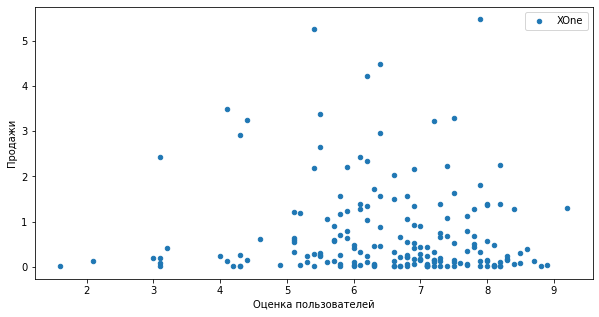

Корреляция между оценками пользователей и продажами по платформе PC  = -0.0938418695247674


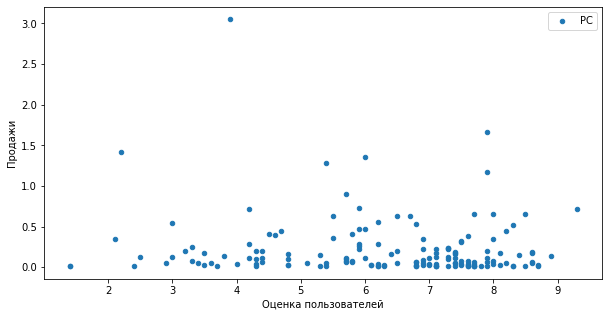

Корреляция между оценками пользователей и продажами по платформе WiiU  = 0.4193304819266187


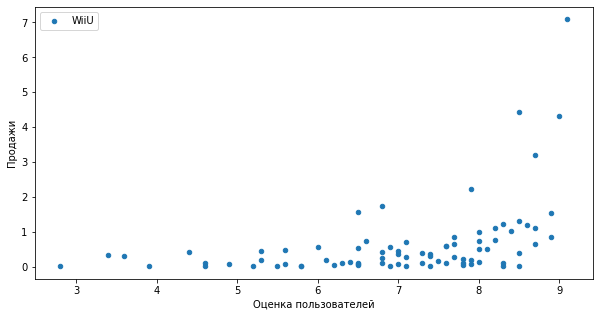

Корреляция между оценками пользователей и продажами по платформе 3DS  = 0.24150411773563016


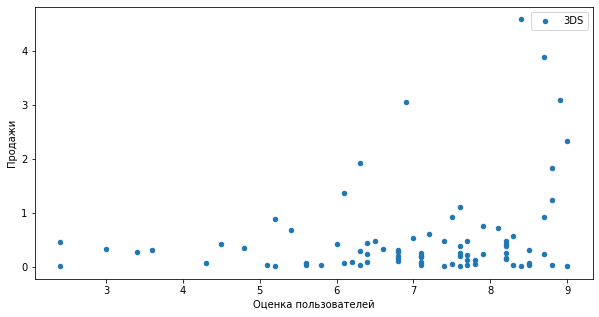

Корреляция между оценками пользователей и продажами по платформе PSV  = 0.0009424723319108626


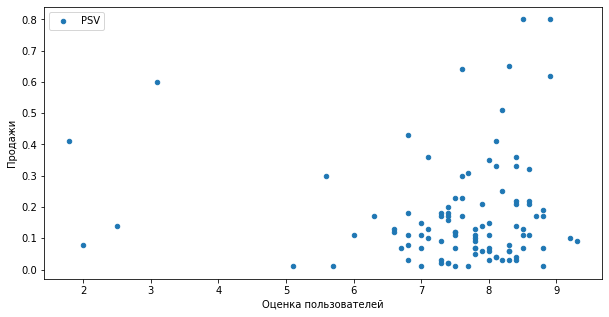

In [35]:
other_platforms = ['XOne','PC','WiiU','3DS', 'PSV']

for b in other_platforms:
    (
    filtered_df.query('platform == @b and user_score > -1')
        .plot(x='user_score', 
          y='total_sales', 
          kind='scatter', 
          figsize=(10, 5))
    )
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи')
    plt.legend([b])
    print(f'Корреляция между оценками пользователей и продажами по платформе {b}  =', filtered_df.query('platform == @b and user_score > -1')['user_score'].corr(filtered_df.query('platform == @b and user_score > -1')['total_sales']))
    plt.show()

*Построим диаграммы рассеяния с оценкой критиков и продажами*

Корреляция между оценками критиков и продажами по платформе XOne  = 0.4169983280084017


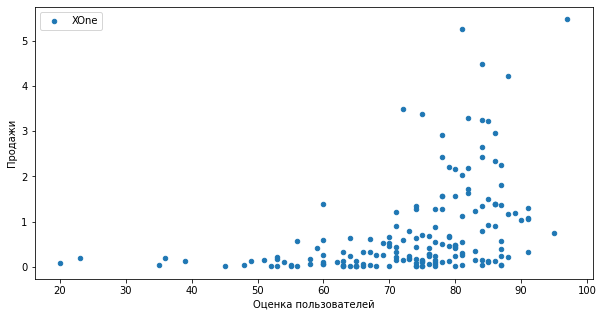

Корреляция между оценками критиков и продажами по платформе PC  = 0.19603028294369382


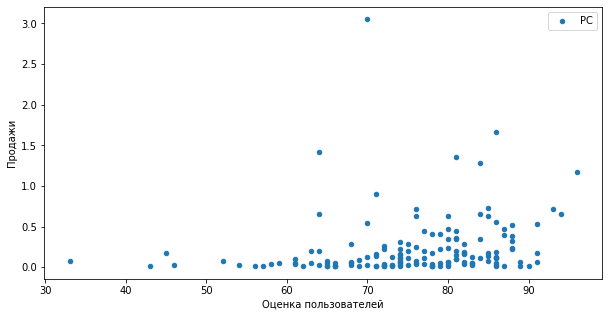

Корреляция между оценками критиков и продажами по платформе WiiU  = 0.3764149065423912


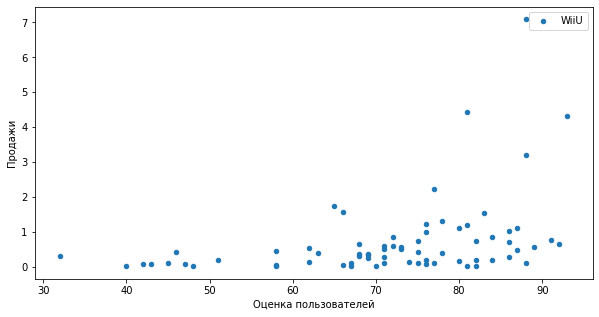

Корреляция между оценками критиков и продажами по платформе 3DS  = 0.3570566142288103


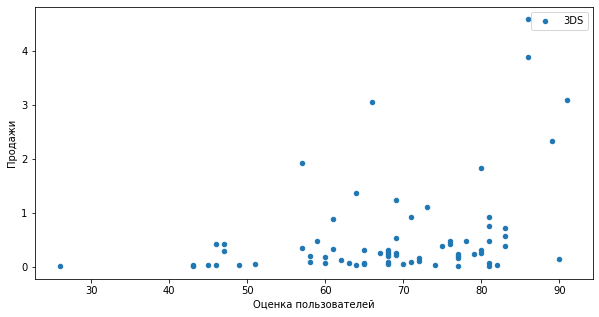

Корреляция между оценками критиков и продажами по платформе PSV  = 0.2547423503068656


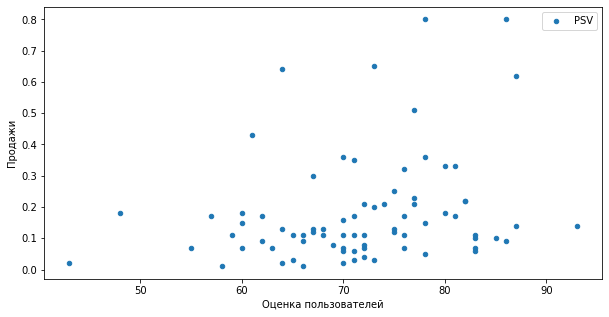

In [36]:
for b in other_platforms:
    (
    filtered_df.query('platform == @b and critic_score > -1')
        .plot(x='critic_score', 
          y='total_sales', 
          kind='scatter', 
          figsize=(10, 5))
    )
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Продажи')
    plt.legend([b])
    print(f'Корреляция между оценками критиков и продажами по платформе {b}  =', filtered_df.query('platform == @b and critic_score > -1')['critic_score'].corr(filtered_df.query('platform == @b and critic_score > -1')['total_sales']))
    plt.show()

*Проведем корреляцию для тех же платформ*

In [37]:
# Комментарий ревьюера 4
print(len(filtered_df.query("critic_score > -1")))
print(len(filtered_df.query("user_score > -1")))
print(len(filtered_df.query("critic_score > -1 & user_score > -1")))

991
1192
976


Вывод: слабая связь между оценками и продажами наблюдается у всех исследуемых платформ, но среди них можно выделить WiiU и PSV, корреляция между оценками пользователей и продаж которых гораздо выше других. То же касается и корреляции между оценками критиков и продажами у тех же платформ.

**Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?**

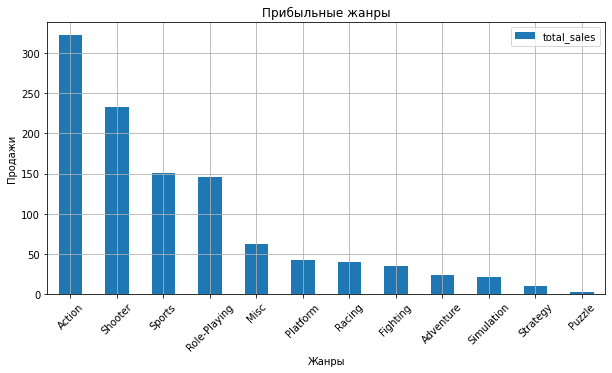

In [38]:
(
    filtered_df.pivot_table(index='genre', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales', ascending=False)
    .plot(kind='bar', grid=True, figsize=(10, 5))
)
plt.title('Прибыльные жанры')
plt.xlabel('Жанры')
plt.ylabel('Продажи')
plt.xticks(rotation=45)
plt.show()

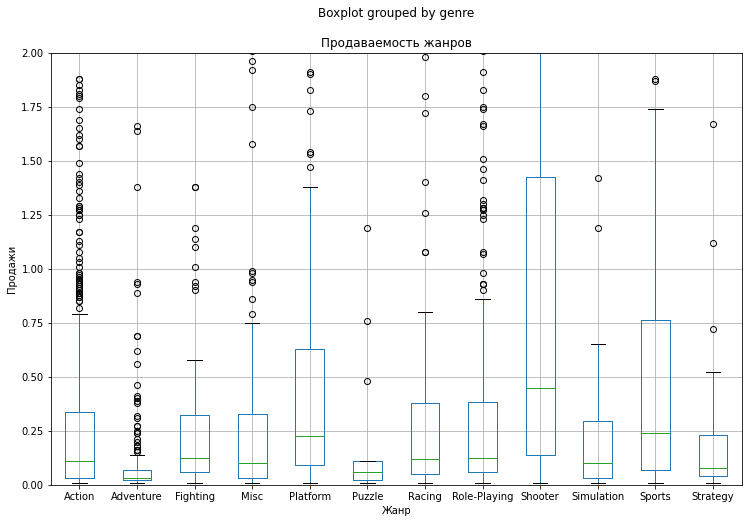

In [39]:
filtered_df.boxplot(by='genre', column=['total_sales'], figsize=(12, 8))
plt.ylim(0,2)
plt.title('Продаваемость жанров')
plt.xlabel('Жанр')
plt.ylabel('Продажи')
plt.show()

Вывод: в период с 2013 по 2016 год жанр Action является самым продаваемым жанром, но Shooter является самым прибыльным жанром. Action - широкоиспользуемый жанр во многих играх, а Shooter - самый популярный. Жанр Puzzle выделяется среди других жанров своей низкой продаваемостью, а Adventure - своей непопулярностью. Возможно, это связано с тем, что вряд ли геймеру захочется переиграть игры этих жанров, как это может быть, например, с Shooter.

Вывод по 3 шагу: 
- пик выпуска игр приходится на 2008-2009 годы. С 1992 года наблюдается рост количества выпущенных игр
- больше всего продала игр платформа PS2
- жизненный цикл платформ в среднем занимает 10 лет
- с 2013 года лидируют платформы PS4 и XOne, но продажи резко снизились в 2015 году
- продажи слабо зависят от оценок, но оценка критиков имеет гораздо больший вес, чем оценка пользователей
- в период с 2013 по 2016 год жанр Action является самым продаваемым жанром, но Shooter является самым прибыльным жанром.

**Шаг 4. Составим портрет пользователя каждого региона**

**Определим для пользователя каждого региона (NA, EU, JP):**
- Самые популярные платформы (топ-5).

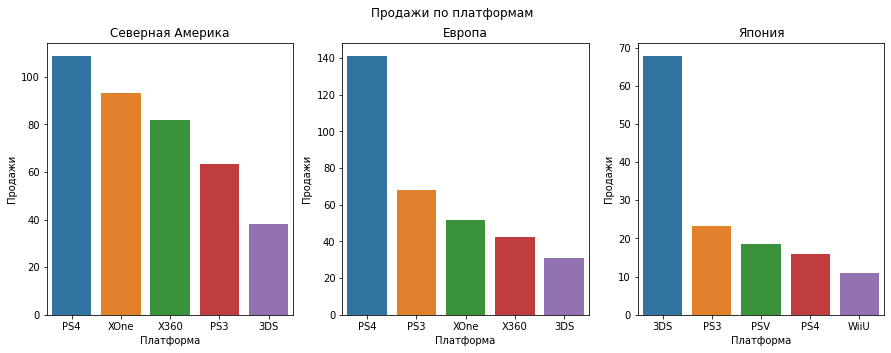

In [40]:
na = filtered_df.groupby('platform')['na_sales'].agg(na='sum').nlargest(5, 'na').reset_index()
eu = filtered_df.groupby('platform')['eu_sales'].agg(eu='sum').nlargest(5, 'eu').reset_index()
jp = filtered_df.groupby('platform')['jp_sales'].agg(jp='sum').nlargest(5, 'jp').reset_index()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Продажи по платформам')

sns.barplot(y='na', x='platform', data=na, ax=ax[0])
ax[0].set_title('Северная Америка')
ax[0].set_ylabel('Продажи')
ax[0].set_xlabel('Платформа')

sns.barplot(y='eu', x='platform', data=eu, ax=ax[1])
ax[1].set_title('Европа')
ax[1].set_ylabel('Продажи')
ax[1].set_xlabel('Платформа')

sns.barplot(y='jp', x='platform', data=jp, ax=ax[2])
ax[2].set_title('Япония')
ax[2].set_ylabel('Продажи')
ax[2].set_xlabel('Платформа')
plt.show()

Вывод: в Северной Америке и Европе PS4 занимает первое место, а в Японии - это 3DS. А в Северной Америке и Европе 3DS занимает последнее место. В Японии на последнем месте стоит WiiU.

- Самые популярные жанры (топ-5). 

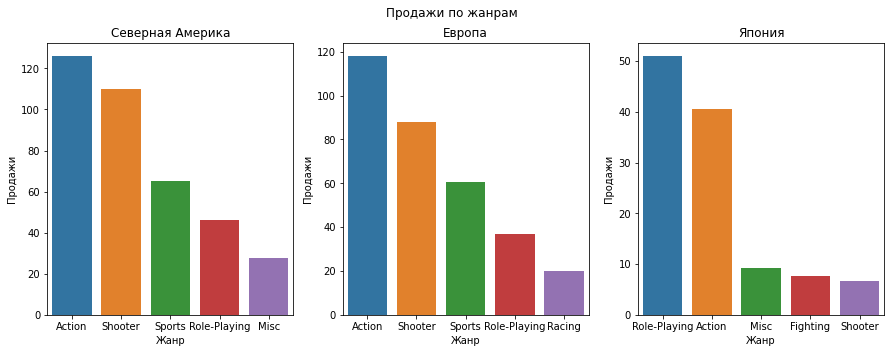

In [41]:
na = filtered_df.groupby('genre')['na_sales'].agg(na='sum').nlargest(5, 'na').reset_index()
eu = filtered_df.groupby('genre')['eu_sales'].agg(eu='sum').nlargest(5, 'eu').reset_index()
jp = filtered_df.groupby('genre')['jp_sales'].agg(jp='sum').nlargest(5, 'jp').reset_index()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Продажи по жанрам')

sns.barplot(y='na', x='genre', data=na, ax=ax[0])
ax[0].set_title('Северная Америка')
ax[0].set_ylabel('Продажи')
ax[0].set_xlabel('Жанр')

sns.barplot(y='eu', x='genre', data=eu, ax=ax[1])
ax[1].set_title('Европа')
ax[1].set_ylabel('Продажи')
ax[1].set_xlabel('Жанр')

sns.barplot(y='jp', x='genre', data=jp, ax=ax[2])
ax[2].set_title('Япония')
ax[2].set_ylabel('Продажи')
ax[2].set_xlabel('Жанр')
plt.show()

Вывод: жанр Action занял первое место по продажам в Северной Америке и Европе, а в Японии это Role-Playing. Последние места занимают Misc в Северной Америке, Racing - в Европе, и Shooter - в Японии.

- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

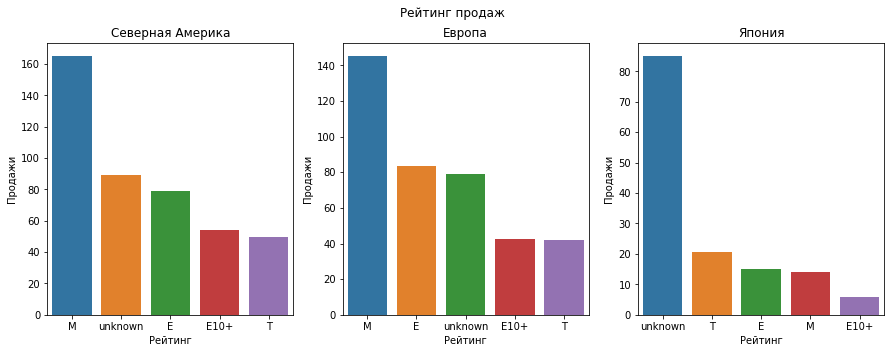

In [42]:
na = filtered_df.groupby('rating')['na_sales'].agg(na='sum').nlargest(5, 'na').reset_index()
eu = filtered_df.groupby('rating')['eu_sales'].agg(eu='sum').nlargest(5, 'eu').reset_index()
jp = filtered_df.groupby('rating')['jp_sales'].agg(jp='sum').nlargest(5, 'jp').reset_index()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Рейтинг продаж')

sns.barplot(y='na', x='rating', data=na, ax=ax[0])
ax[0].set_title('Северная Америка')
ax[0].set_ylabel('Продажи')
ax[0].set_xlabel('Рейтинг')

sns.barplot(y='eu', x='rating', data=eu, ax=ax[1])
ax[1].set_title('Европа')
ax[1].set_ylabel('Продажи')
ax[1].set_xlabel('Рейтинг')

sns.barplot(y='jp', x='rating', data=jp, ax=ax[2])
ax[2].set_title('Япония')
ax[2].set_ylabel('Продажи')
ax[2].set_xlabel('Рейтинг')
plt.show()

Расшифровка рейтинга возрастной категории:
- EC - Для детей младшего возраста.
- E - Подходит для всех возрастных категорий.
- E10+ - Подходит для лиц старше 10 лет. 
- T - Подходит для лиц старше 13 лет.
- M - Подходит для лиц старше 17 лет.
- AO - Подходит для взрослых старше 18 лет. 
- RP - Категория ещё не присвоена.

Вывод: в Северной Америке и Европе первое место занял рейтинг M (для лиц старше 17 лет), в Японии - T (для лиц старше 13 лет), так как категория, занимающая первое месте, еще не определена. В это же время категория T стоит на последнем месте в Северной Америке и Европе. В Японии на последнем месте стоит рейтинг E10+ (для лиц старше 10 лет).

Вывод по 4 шагу: портрет пользователя в Северной Америке и Европе очень похож. Пользователи данных стран предпочитают играть на платформе PS4, игры жанра Action и возрастную категорию старше 17 лет. В Японии портрет пользователя совершенно отличается - предпочтение отдается игровой платформе 3DS, играм жанра Role-Playing не определенной возрастной категории.

**Шаг 5. Проверим гипотезы**

- H0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- H1: Средние пользовательские рейтинги платформ Xbox One и PC разные

In [43]:
xbox_rating = filtered_df.query('platform == "XOne" and user_score > 0')
pc_rating = filtered_df.query('platform == "PC" and user_score > 0')

results = st.ttest_ind(xbox_rating['user_score'], pc_rating['user_score'], equal_var=False, alternative='two-sided')
print('p-значение:', results.pvalue)

alpha = 0.05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.14759594013430463
Не получилось отвергнуть нулевую гипотезу


In [44]:
xbox_rating['user_score'].describe()

count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64

In [45]:
pc_rating['user_score'].describe()

count    155.000000
mean       6.269677
std        1.742381
min        1.400000
25%        5.300000
50%        6.800000
75%        7.600000
max        9.300000
Name: user_score, dtype: float64

Вывод: не отвергаем нулевую гипотезу, значит может имеем право полагать, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые при пороговом значении 0,05.

In [46]:
filtered_scores = filtered_df[filtered_df['user_score'] > 0]
mean_score_by_platform = filtered_scores.groupby('platform')['user_score'].mean().reset_index()
mean_score_by_platform = mean_score_by_platform.sort_values(by='user_score', ascending=False)
display(mean_score_by_platform)

,platform,user_score
6,PSV,7.527273
8,WiiU,7.017500
0,3DS,6.976250
4,PS4,6.748249
10,XOne,6.521429
3,PS3,6.348387
2,PC,6.269677
9,X360,5.993007
5,PSP,5.850000
7,Wii,5.257143


Проверим еще одну гипотезу:
- H0: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.
- H1: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

In [47]:
action_rating = filtered_df.query('genre == "Action" and user_score > 0')
sports_rating = filtered_df.query('genre == "Sports" and user_score > 0')

results = st.ttest_ind(action_rating['user_score'], sports_rating['user_score'], equal_var=False, alternative='two-sided')
print('p-значение:', results.pvalue)

alpha = 0.05
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


In [48]:
action_rating['user_score'].describe()

count    389.000000
mean       6.837532
std        1.330173
min        2.000000
25%        6.300000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64

In [49]:
sports_rating['user_score'].describe()

count    160.000000
mean       5.238125
std        1.783427
min        0.200000
25%        4.100000
50%        5.500000
75%        6.500000
max        8.800000
Name: user_score, dtype: float64

Вывод: отвергаем нулевую гипотезу, соответственно, мы можем сказать, что средние пользовательские рейтинги жанров Action и Sports разные при пороговом значении 0,05.

In [50]:
filtered_scores = filtered_df[filtered_df['user_score'] > 0]
mean_score_by_genre = filtered_scores.groupby('genre')['user_score'].mean().reset_index()
mean_score_by_genre = mean_score_by_genre.sort_values(by='user_score', ascending=False)
display(mean_score_by_genre)

,genre,user_score
5,Puzzle,7.471429
1,Adventure,7.461667
7,Role-Playing,7.376471
2,Fighting,7.037500
3,Misc,6.975000
0,Action,6.837532
4,Platform,6.713793
8,Shooter,6.342308
11,Strategy,6.183333
6,Racing,6.080000


Пояснения: 
- Как вы сформулировали нулевую и альтернативную гипотезы: если значений в выборке много (30 и больше), то распределение Стьюдента настолько близко к нормальному, что можно было бы просто взять нормальное распределение без степеней свободы.
- Какой критерий применили для проверки гипотез и почему: мы применяли статистический тест на равенство среднего генеральной совокупности с использованием t-теста (распределение Стьюдента).

**Шаг 6. Общий вывод**

В ходе анализа данных интернет-магазина "Стримчик" были выполнены следующие шаги:

1. Изучена общая информация
- датафрейм содержит 16715 записей
- названия столбцов некорректные, нужно привести к нижнему регистру
- в таблице есть пропуски
- у некоторых столбцов некорректный тип данных.

2. Подготовка данных
- дубликатов в таблице нет
- привели названия столбцов к нижнему регистру
- обработали пропуски
- изменили тип данных
- посчитали суммарные продажи во всех регионах
- разобрали значение tbd ("будет определено позже", то есть оценку еще не поставили).

    Пропусками могли послужить человеческий фактор и сбои в программе.
    
3. Провели исследовательский анализ данных
- пик выпуска игр приходится на 2008-2009 годы. С 1992 года наблюдается рост количества выпущенных игр
- больше всего продала игр платформа PS2
- жизненный цикл платформ в среднем занимает 10 лет
- с 2013 года лидируют платформы PS4 и XOne, но продажи резко снизились в 2015 году
- продажи слабо зависят от оценок, но оценка критиков имеет гораздо больший вес, чем оценка пользователей
- в период с 2013 по 2016 год жанр Action является самым продаваемым жанром, но Shooter является самым прибыльным жанром.

4. Составили портрет пользователя каждого региона
    Портрет пользователя в Северной Америке и Европе очень похож. Пользователи данных стран предпочитают играть на платформе PS4, игры жанра Action и возрастную категорию старше 17 лет. В Японии портрет пользователя совершенно отличается - предпочтение отдается игровой платформе 3DS, играм жанра Role-Playing не определенной возрастной категории.
    
    
5. Не отвергаем нулевую гипотезу, значит может имеем право полагать, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые при пороговом значении 0,05.  отвергаем нулевую гипотезу, соответственно, мы можем сказать, что средние пользовательские рейтинги жанров Action и Sports разные при пороговом значении 0,05.

В 2017 году интернет-магазин "Стимчик" может спланировать рекламную кампанию в отношении игр возрастной категории M (для Северной Америки и Европы), T (для Японии), E (для Европы) и жанра Action и Shooter, отличительные черты которых являются активный геймплей и сражения, так как они в последнее время набирают все большую популярность. Также можно выделить деньги на рекламную кампанию на платформы PS4 (для геймеров в Северной Америке и Европе) и 3DS (в Японии). Реклама жанра Action отлично подойдет для всех регионов, а Shooter - для Северной Америки и Европы. Если хватит рекламного бюджета, можно еще пропрекламировать Role-Playing для пользователей Японии. Вдобавок, не всегда стоит обращать внимание на отзывы пользователей, так как они не влияют на продаваемость и популярность игры, но можно прислушаться к критикам, они дают более информативные оценки.